## Introduction
This tutorial provides a step-by-step guide on how to use the Precision-Recall metric to evaluate classifier output quality. The Precision-Recall curve is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

## Dataset and Model
We will use the iris dataset and a Linear SVC classifier to differentiate two types of irises. First, we will import the necessary libraries and load the dataset.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X, y = load_iris(return_X_y=True)

<br><br>Next, we will add noisy features to the dataset and split it into training and test sets.<br><br><br>

In [2]:
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X[y < 2], y[y < 2], test_size=0.5, random_state=random_state
)

<br><br>Finally, we will scale the data using a StandardScaler and fit a Linear SVC classifier to the training data.<br><br><br>

In [3]:
classifier = make_pipeline(
    StandardScaler(), LinearSVC(random_state=random_state, dual="auto")
)
classifier.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(random_state=RandomState(MT19937) at 0x2A083DD6D40))])

## Plot the Precision-Recall Curve
To plot the Precision-Recall curve, we will use the PrecisionRecallDisplay class from the sklearn.metrics library. We can use either from_estimator or from_predictions method to compute the curve. The from_estimator method computes the predictions for us before plotting the curve, while the from_predictions method requires us to provide the predicted scores.

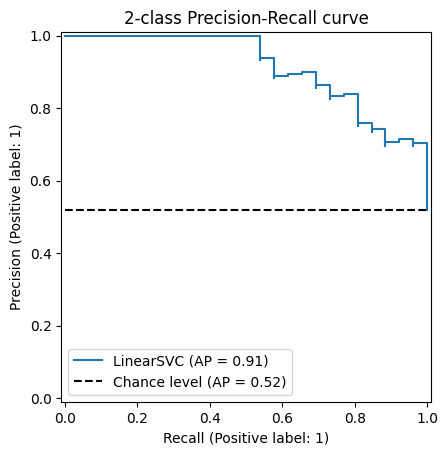

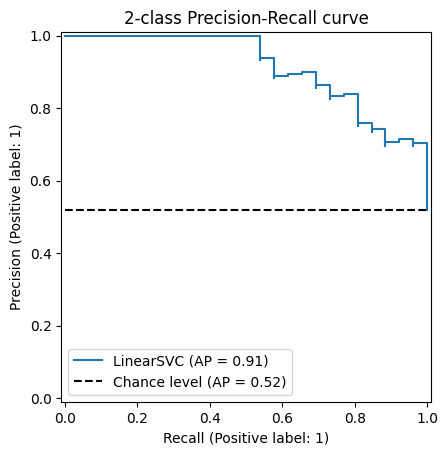

In [4]:
from sklearn.metrics import PrecisionRecallDisplay

# Using from_estimator method
display = PrecisionRecallDisplay.from_estimator(
    classifier, X_test, y_test, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Using from_predictions method
y_score = classifier.decision_function(X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Plot Precision-Recall Curve for Multi-Label Classification
The Precision-Recall curve does not support the multi-label setting. However, one can decide how to handle this case. We will create a multi-label dataset, fit and predict using OneVsRestClassifier and then plot the Precision-Recall curve.

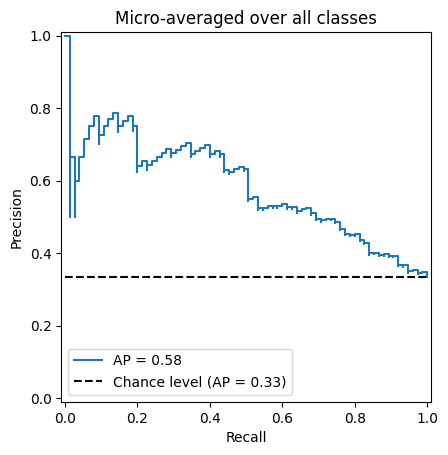

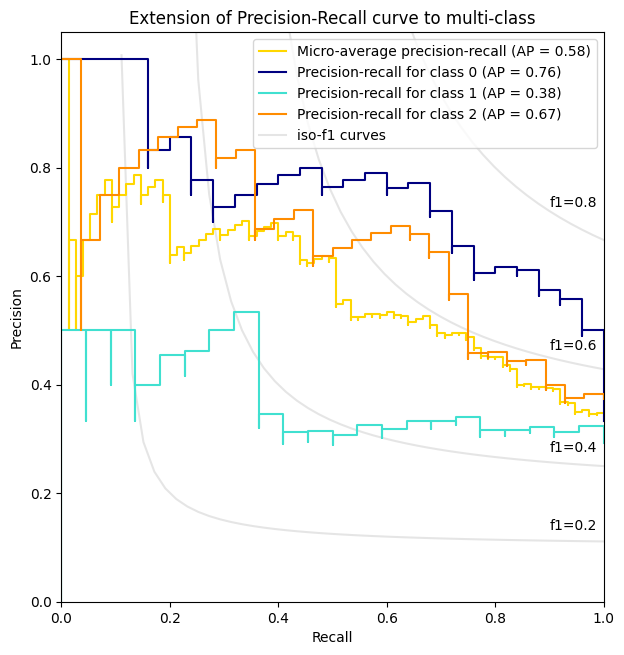

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from collections import Counter
from itertools import cycle
import matplotlib.pyplot as plt

# Create multi-label data
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=random_state
)

# Fit and predict using OneVsRestClassifier
classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state, dual="auto"))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

# Calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# Calculate micro-averaged precision and recall
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

# Plot the micro-averaged Precision-Recall curve
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(Y_test.ravel())[1] / Y_test.size,
)
display.plot(plot_chance_level=True)
_ = display.ax_.set_title("Micro-averaged over all classes")

# Plot Precision-Recall curve for each class and iso-f1 curves
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
_, ax = plt.subplots(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")
plt.show()

## Summary
This tutorial provided a step-by-step guide on how to use the Precision-Recall metric to evaluate classifier output quality. We learned how to plot the Precision-Recall curve for binary classification using the PrecisionRecallDisplay class from the sklearn.metrics library. We also learned how to plot the Precision-Recall curve for multi-label classification using OneVsRestClassifier and how to calculate precision and recall for each class.